In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import evofr as ef
import matplotlib.pyplot as plt

In [2]:
# Getting data
raw_seq = pd.read_csv("../data/pango_location-variant-sequence-counts.tsv", sep="\t")
# raw_variant_parents is missing a row for BA.2, so append one
raw_variant_parents = pd.concat((pd.read_csv("../data/pango_variant-relationships.tsv", sep="\t"),
                                pd.DataFrame({"variant": ["BA.2"], "parent": ["base"]}))).reset_index(drop=True)
variant_frequencies = ef.InnovationSequenceCounts(raw_seq, raw_variant_parents, pivot="BA.2")

In [3]:
# Defining model
mlr = ef.InnovationMLR(tau=4.2)

In [4]:
# Defining inference method
inference_method = ef.InferFullRank(iters=50_000, lr=4e-3, num_samples=100)

In [5]:
# Fitting model
posterior = inference_method.fit(mlr, variant_frequencies)
samples = posterior.samples

Text(0, 0.5, 'loss')

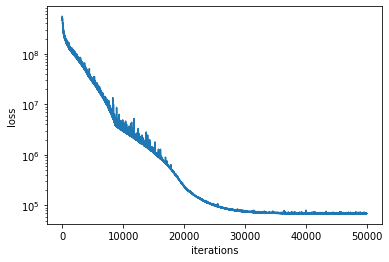

In [6]:
plt.plot(posterior.samples["losses"])
plt.yscale("log")
plt.xlabel("iterations")
plt.ylabel("loss")

In [7]:
ga = samples["ga"]

In [8]:
ga.shape

(100, 180)

In [9]:
type(ga)

jaxlib.xla_extension.DeviceArray

In [10]:
posterior.data.var_names[:10]

['B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.1.1.1',
 'BA.1.1.10',
 'BA.1.1.14',
 'BA.1.1.16',
 'BA.1.1.18',
 'BA.1.1.2',
 'BA.1.15']

In [11]:
ga_df = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples, posterior.data, ps=[0.8], name="USA", rel_to="BA.2")
)
ga_df.head(10)

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,B.1.1.529,1.6224344,1.6343935,1.6137043
1,USA,BA.1,0.64707136,0.64927614,0.6447943
2,USA,BA.1.1,0.67559946,0.67707634,0.6737089
3,USA,BA.1.1.1,0.6597877,0.6785018,0.6395522
4,USA,BA.1.1.10,0.7546855,0.7697933,0.7416856
5,USA,BA.1.1.14,0.6887062,0.7039045,0.6741283
6,USA,BA.1.1.16,0.72850907,0.7389129,0.71646434
7,USA,BA.1.1.18,0.6404326,0.6457438,0.6337965
8,USA,BA.1.1.2,0.63039804,0.6491891,0.61385804
9,USA,BA.1.15,0.62678415,0.6332088,0.6217066


In [12]:
ga_df.to_csv('growth_advantages.tsv', sep="\t")

In [13]:
def get_growth_advantage_delta(samples, data, ps, name, rel_to="other"):
    # Unpack variant info
    var_names = data.var_names
    par_names = [data.parent_map[v] for v in var_names]

    # Get posterior samples
    ga = jnp.array(jnp.exp(samples["delta"]))
    N_variant = ga.shape[-1]

    # Loop over ga and make relative rel_to
    for i, s in enumerate(var_names):
        if s == rel_to:
            ga = jnp.divide(ga, ga[:, i][:, None])

    #ga = jnp.divide(ga, ga[:, var_names.index(rel_to)][:, None])

    # Compute medians and quantiles
    meds = jnp.median(ga, axis=0)
    gas = []
    for i, p in enumerate(ps):
        up = 0.5 + p / 2
        lp = 0.5 - p / 2
        gas.append(jnp.quantile(ga, jnp.array([lp, up]), axis=0).T)

    # Make empty dictionary
    v_dict = dict()
    v_dict["location"] = []
    v_dict["variant"] = []
    v_dict["parent"] = []
    v_dict["median_ga_delta"] = []

    for p in ps:
        v_dict[f"ga_delta_upper_{round(p * 100)}"] = []
        v_dict[f"ga_delta_lower_{round(p * 100)}"] = []

    for variant in range(N_variant):
        if var_names[variant] != rel_to:
            v_dict["location"].append(name)
            v_dict["variant"].append(var_names[variant])
            v_dict["parent"].append(par_names[variant])
            v_dict["median_ga_delta"].append(meds[variant])
            for i, p in enumerate(ps):
                v_dict[f"ga_delta_upper_{round(p * 100)}"].append(gas[i][variant, 1])
                v_dict[f"ga_delta_lower_{round(p * 100)}"].append(gas[i][variant, 0])

    return v_dict

In [14]:
ga_delta_df = pd.DataFrame(
    get_growth_advantage_delta(samples, variant_frequencies, [0.8], "USA", rel_to="BA.2")
)
ga_delta_df.head(10)

,location,variant,parent,median_ga_delta,ga_delta_upper_80,ga_delta_lower_80
0,USA,B.1.1.529,BA.2,1.1221213,1.1240851,1.1206807
1,USA,BA.1,BA.2,0.90154755,0.90227795,0.9007911
2,USA,BA.1.1,BA.1,1.0103419,1.0110389,1.0095108
3,USA,BA.1.1.1,BA.1.1,0.99437845,1.001341,0.9872526
4,USA,BA.1.1.10,BA.1.1,1.0269046,1.0317016,1.0229573
5,USA,BA.1.1.14,BA.1.1,1.0047157,1.0095304,0.99963236
6,USA,BA.1.1.16,BA.1.1,1.0184286,1.0218478,1.0141922
7,USA,BA.1.1.18,BA.1.1,0.987587,0.9892881,0.9850956
8,USA,BA.1.1.2,BA.1.1,0.9837519,0.9907564,0.9776236
9,USA,BA.1.15,BA.1,0.99258876,0.9945248,0.9908046


In [15]:
ga_delta_df.to_csv('growth_advantages_delta.tsv', sep="\t")